# Efficient CNN
by: Celine Lin z5311209

## Introduction
In the modern world, driving is one of the most essential modes of transportation. In order to prevent drivers from disobeying traffic signs, avoid dangers, and promote safer driving, this computer vision project focuses on developing efficient Convolutional Neural Network that employ forward-sensing cameras to recognise traffic signals. 

## Exploratory Analysis of Data: 
Source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign.

This model is applied on the dataset of GTSRB - German Traffic Sign Recognition Benchmark from kaggle. The reason of choosing this dataset is beacause it is a large, lifelike database, containing 43 classes of images and more than 50,000 images. In addition, the images are in RGB with 30x30 pixels and the test folder contains 12.6k images. What's more, the size of images is between 30 x 25 and 266 x 232.

The preprocessing is to resize all images to one size. Larger resolution of image would increase the accuracy of training. However, due to the lack of memory storage, the maximum size of image can be resized to 32x32 pixels. Hence, all the images are resized to 32x32 pixels.

#### Visualise data

In [ ]:
# fixed constant for size (image size may be different for diffent models)
HEIGHT = 32
WIDTH = 32

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os

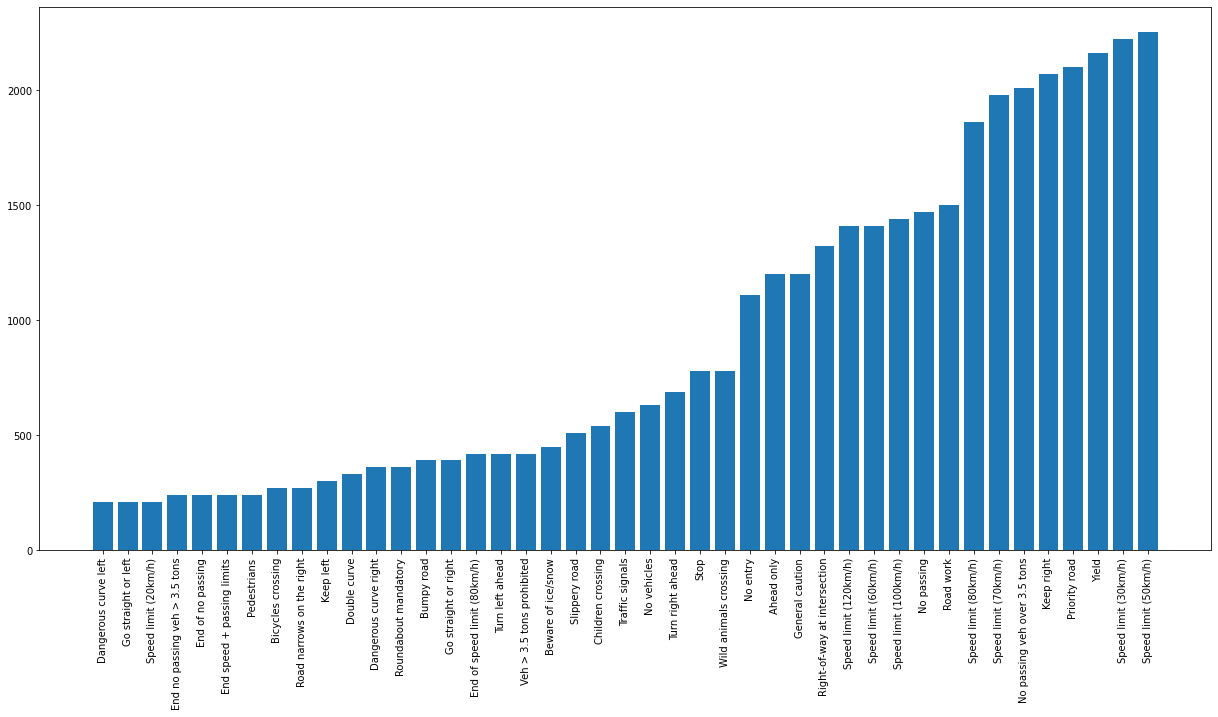

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

trainFolder = '/kaggle/input/gtsrb-german-traffic-sign/Train'
trainFolders = os.listdir(trainFolder)

trainNumber = []
classNum = []

for folder in trainFolders:
    trainFiles = os.listdir(trainFolder + '/' + folder)
    trainNumber.append(len(trainFiles))
    classNum.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipList = zip(trainNumber, classNum)
sortedPairs = sorted(zipList)
tuples = zip(*sortedPairs)
trainNumber, classNum = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(classNum, trainNumber)
plt.xticks(classNum, rotation='vertical')
plt.show()

#### Read and Resize Data

In [ ]:
trainData = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv', usecols=['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId'])

features = []
for feature in trainData.columns:
    if feature != 'ClassId':
        features.append(feature)
X = trainData[features]
y = np.array(trainData['ClassId'])

# Read all folders in the folderPath and combine the files together into a list
fileList = []
for i in range(43) :
    path = "/kaggle/input/gtsrb-german-traffic-sign/train/{0}/".format(i)
    trainFiles = os.listdir(path)
    for img in trainFiles:
        try:
            image=cv2.imread(path + img)
            # Convert array to image
            image_f = Image.fromarray(image, 'RGB')
            # resize the image accoding to diffent model
            size_image = image_f.resize((HEIGHT, WIDTH))
            fileList.append(np.array(size_image))
        except:
             print("Error in " + img)
                
image_data = np.array(fileList)
print(image_data.shape, y.shape)

# shuffling
sf_i = np.arange(image_data.shape[0])
np.random.seed(43)
np.random.shuffle(sf_i)
image_data = image_data[sf_i]
y = y[sf_i]

# Splitting training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data, y, test_size=0.2, random_state=42, shuffle=True)
X_train = X_train/255 
X_test = X_test/255
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(39209, 32, 32, 3) (39209,)
(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)


## Model
This model follows the idea of EfficientNet, which is a type of Convolutional Neural Network, where all dimensions of depth/width/resolution increase to achieve higher accuracy. 

To simulate this net, six convolutional layers are added to increase the depth of the model. In each convolutional layer, the width increases by changing the filter, and in order to increase the nonlinear relationship between the layers in the model, we set the activation to ReLU. However, the lack of memory storage cannot increase image resolution. Hence, by comparing to the general EfficientNet, this model only follows the idea of increasing depth and width. 

GlobalAveragePooling2D is also added to decrease the dimensions of the feature maps at the end to achieve higher accuracy. As the model is deep, 2d Dropout is used after every convolutional layer, by testing the best parameter for dropout is 0.5, and accelerates training using Batchnormalization to prevent overfitting. Finally, after softmax processing, we will output 43 classified results.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Normalization, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D

model = Sequential([
    BatchNormalization(input_shape=(HEIGHT, WIDTH, 3)),
    Conv2D(16,3,activation='relu'),
    SpatialDropout2D(0.05),
    
    BatchNormalization(),
    Conv2D(32,3, activation = 'relu'),
    SpatialDropout2D(0.05),
    MaxPool2D(pool_size=(2, 2)),
    
    BatchNormalization(),
    Conv2D(64,3, activation = 'relu'),
    SpatialDropout2D(0.05),
    
    BatchNormalization(),
    Conv2D(128,3, activation = 'relu'),
    SpatialDropout2D(0.05),
    MaxPool2D(pool_size=(2, 2)),
    
    BatchNormalization(),
    Conv2D(256,3, activation = 'relu'),
    SpatialDropout2D(0.05),
    
    BatchNormalization(),
    Conv2D(1024,1, activation = 'relu'),
    SpatialDropout2D(0.05),
    
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Flatten(),
    Normalization(),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

       
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
spatial_dropout2d_6 (Spatial (None, 30, 30, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
spatial_dropout2d_7 (Spatial (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)       

#### Training
Train the model for 20 epoch

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
981/981 [==============================] - 11s 9ms/step - loss: 1.4181 - accuracy: 0.5630 - val_loss: 0.4809 - val_accuracy: 0.8080
Epoch 2/20
981/981 [==============================] - 9s 9ms/step - loss: 0.5331 - accuracy: 0.8012 - val_loss: 0.4220 - val_accuracy: 0.8335
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.4603 - accuracy: 0.8211 - val_loss: 0.3974 - val_accuracy: 0.8435
Epoch 4/20
981/981 [==============================] - 9s 10ms/step - loss: 0.4355 - accuracy: 0.8269 - val_loss: 0.3755 - val_accuracy: 0.8471
Epoch 5/20
981/981 [==============================] - 10s 10ms/step - loss: 0.4229 - accuracy: 0.8313 - val_loss: 0.3770 - val_accuracy: 0.8442
Epoch 6/20
981/981 [==============================] - 9s 9ms/step - loss: 0.4103 - accuracy: 0.8349 - val_loss: 0.3795 - val_accuracy: 0.8456
Epoch 7/20
981/981 [==============================] - 9s 9ms/step - loss: 0.4082 - accuracy: 0.8356 - val_loss: 0.3844 - val_accuracy: 0.8442
Ep

## Result
Visualise the result by ploting the diagram of training accuracy, validation accuracy, training loss and validation loss

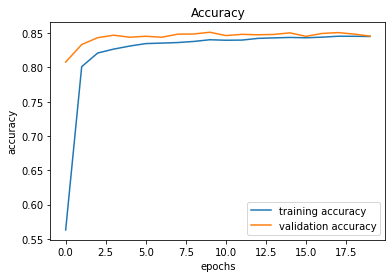

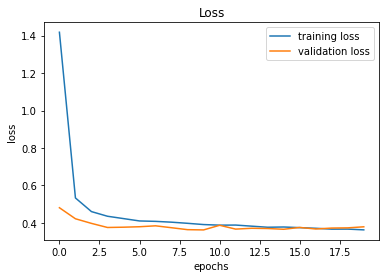

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

We can see the training accuracy is increasing, and the loss decreases, while increases the number of epochs. The accuracy reaches the equilibrium about 4 epochs of 84% training accuracy.

In [ ]:
testData = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
test_imgs = testData["Path"].values
test_labels = testData["ClassId"].values

# Read all folders in the folderPath and combine the files together into a list
fileList = []
for img in test_imgs:
    image = cv2.imread('/kaggle/input/gtsrb-german-traffic-sign/' + img)
    # Convert array to image
    image_f = Image.fromarray(image, 'RGB')
    # resize the image accoding to diffent model
    size_image = image_f.resize((HEIGHT, WIDTH))
    fileList.append(np.array(size_image))

x_test = np.array(fileList)
x_test = x_test.astype('float32') /255
y_predict = np.argmax(model.predict(x_test), axis=1)

from sklearn.metrics import accuracy_score
print('Test accuracy: ', accuracy_score(test_labels, y_predict))

Test accuracy:  0.9345209817893904


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.98      1.00      0.99       720
           2       0.94      0.99      0.97       750
           3       0.99      0.98      0.99       450
           4       0.99      0.99      0.99       660
           5       0.80      0.97      0.88       630
           6       0.00      0.00      0.00       150
           7       0.97      1.00      0.98       450
           8       1.00      0.94      0.96       450
           9       0.95      1.00      0.97       480
          10       0.99      0.97      0.98       660
          11       0.94      0.99      0.96       420
          12       0.97      0.99      0.98       690
          13       0.99      1.00      0.99       720
          14       0.81      0.99      0.89       270
          15       0.49      0.71      0.58       210
          16       0.00      0.00      0.00       150
          17       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The result demonstrates that the model has a high test accuracy - 93%.

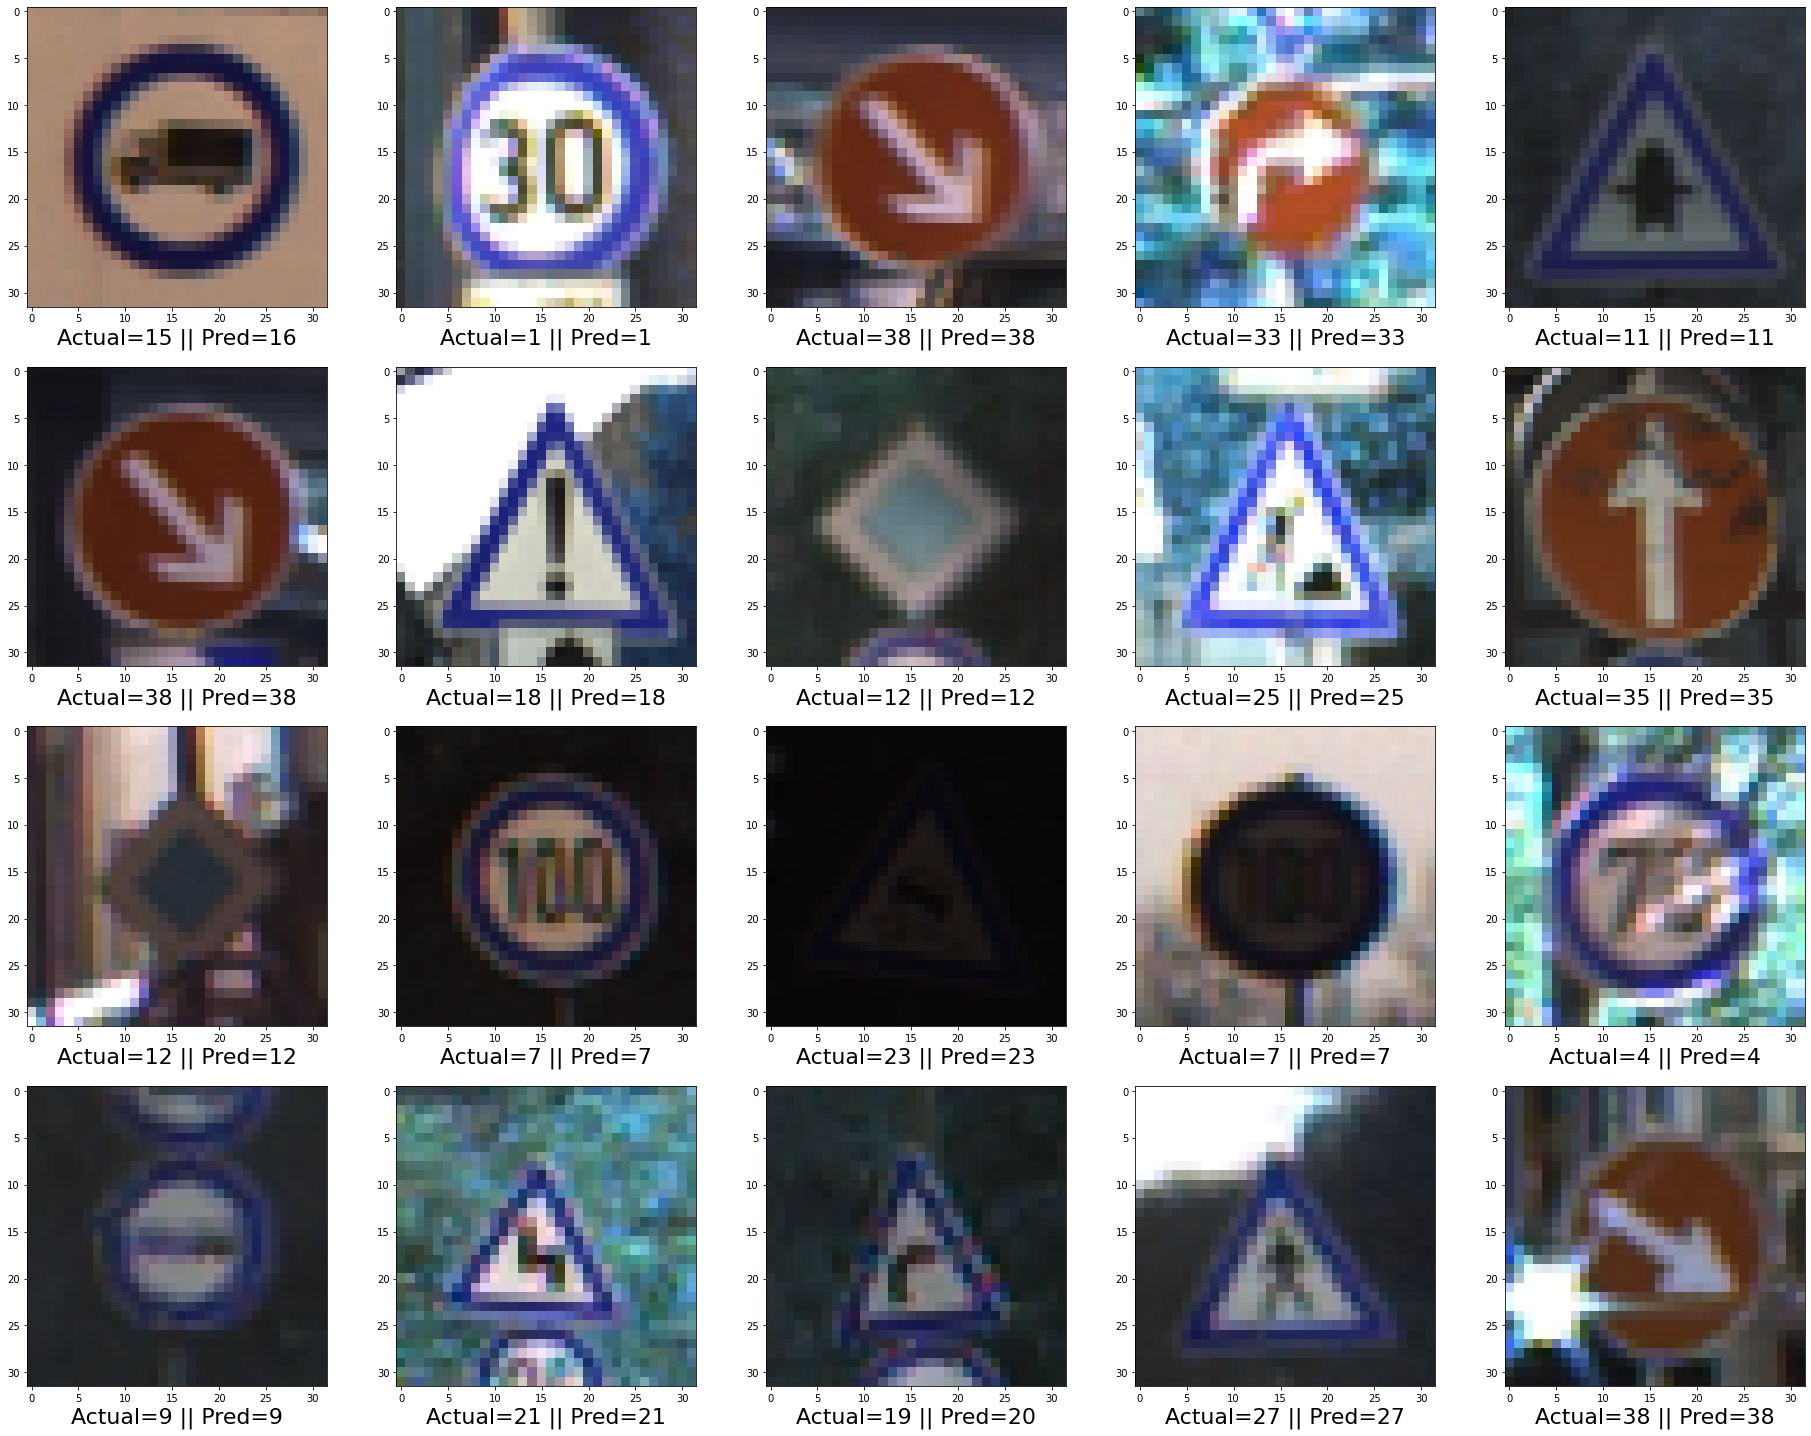

In [ ]:
plt.figure(figsize = (HEIGHT, WIDTH))

start_index = 0
for i in range(20):
    plt.subplot(5, 5, i + 1)
    prediction = test_labels[start_index + i]
    actual = y_predict[start_index + i]
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), fontsize=22)
    plt.imshow(x_test[start_index + i])
plt.show()

## Discussion
The result demonstrates that the model has a relatively high accuracy, with 84% of training accuracy. Since this model is deep and wide, the disadvantage of this is that the training time would be longer than simple models.  However, this model can train more complex resources for future applications.
